3 methods used to determine how our covnets interpret and perform the tasks:
1. Visualizing intermediate activations
2. Visualizing covnet filters
3. Visualizing heatmaps of class activation in an image


In [1]:
# Visualizing intermediate activations : Displaying the values returned by various convolution and pooling layers in a model
# Helps us get an understanding on how the input is decomposed by the different filters learned by the network

In [2]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Importing my previous model created in CNN from scratch notebook

model = keras.models.load_model('Cats_vs_Dogs_Best_Model_data_augmentation.keras')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

In [4]:
img_path = "artifacts\dogs_vs_cats\cat.4.jpg" # Image saved in my local folder(taken from test dataset of dogs vs cats)

# Function to resize the image

def get_img_array(img_path,target_size):
    
    img = keras.utils.load_img(img_path,target_size=target_size) # Loading the image
    img_array = keras.utils.img_to_array(img) # Converting the image to an array
    img_array = np.expand_dims(img_array,axis=0) # Adding an extra dimension to the array (Extra dimension added because our model expects batch size as well)
    
    return img_array

# Image is loaded and resized , converted to numpy array , shape changed from (target_size,3) to (1,target_size,3)
# Where 1 is the batch size 

img_tensor = get_img_array(img_path=img_path,target_size=(180,180))

# Image size changes from (180,180,3) to (1,180,180,3) after adding the new dimension


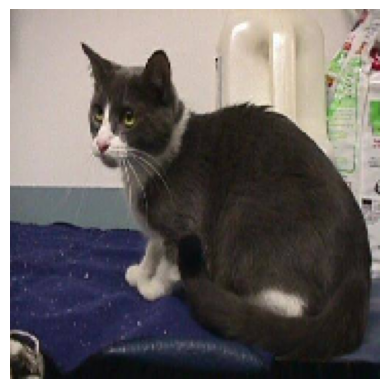

In [5]:
# Displaying the image
plt.axis("off")
plt.imshow(img_tensor[0].astype(np.uint8))
plt.show()

In [6]:
from keras.layers import Conv2D,MaxPool2D
from keras.models import Model

In [7]:
# Creating a model to return the output of each layer

layer_outputs = []
layer_name = []

for layer in model.layers:
    if isinstance(layer,(Conv2D,MaxPool2D)): # If layer is an instance of Conv2D or MaxPool2D then only we are fetching the output
        layer_outputs.append(layer.output)
        layer_name.append(layer.name)
activation_model = Model(inputs=model.input,outputs=layer_outputs) # The activation model will return the outputs of each layer

In [8]:
# We are storing the output list in activations(Input is the tensor created earlier)
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 4s 4s/step


In [9]:
first_activation_layer = activations[0]

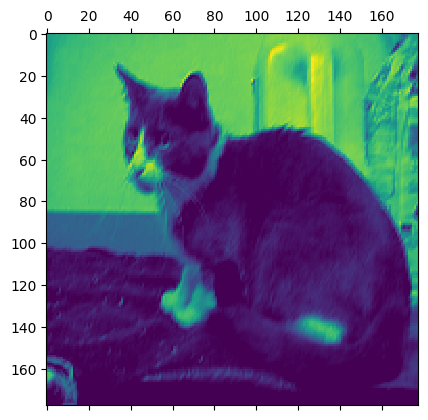

In [10]:
plt.matshow(first_activation_layer[0,:,:,10], cmap="viridis") # Displaying the 10th channel (out of 32 since there are 32 filters used in 1st layer)

In [11]:
second_activation_layer = activations[1]

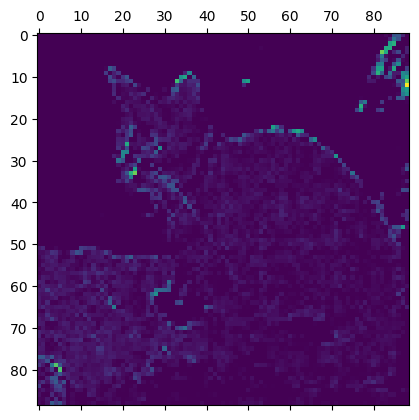

In [12]:
plt.matshow(second_activation_layer[0,:,:,30],cmap="viridis") # 30th channel output (out of 32 since there are 32 filters used in 2nd layer)

In [13]:
# Visualizing covnet filters : Displaying the visual patterns that each filter is meant to respond to. This can be done by applying gradient 
# descent to the value of the input image of a covnet so as to maximize the response of a specific filter.

In [14]:
# We use the pretrained Xception model (removed the classification layers because they are not required)

model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False
)

In [15]:
# We are only interested in the Conv2D and Seperable Conv2D layers

for layer in model.layers:
    if isinstance(layer,keras.layers.Conv2D) or isinstance(layer,keras.layers.SeparableConv2D):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


In [16]:
# Creating a feature extraction model

layer_name = "block3_sepconv1"

layer = model.get_layer(name=layer_name)
feature_extractor = Model(inputs=model.input,outputs=layer.output) # Output will be the layer output of the layer name we select(can be any Conv2D or SeparableConv2D layer)


In [17]:
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor) # Preprocessing our input tensor using the preprocessing function required by xception model
)

In [18]:
# Function used to quantify how much a given input image activates a given filter in the layer (This will be the loss function that we will
# maximize during the gradient ascent process)
def compute_loss(image,filter_index):
    activation = feature_extractor(image) # we got the output of the feature extractor here
    filter_activation = activation[:,2:-2,2:-2,filter_index] #We are avoiding the border pixels 
    return tf.reduce_mean(filter_activation) # Returning the mean of the activation values of the filter

In [19]:
# Here we are using model(x) instead of model.predict(x) because model.predict(x) cannot be used to retrieve the gradients 

In [20]:
@tf.function
def gradient_ascent_step(image,filter_index,learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image) # watching the image tensor explicitly because its not a tensorflow object
        loss = compute_loss(image,filter_index) # calculating the loss 
    grads = tape.gradient(loss,image) # Calculating the gradient of loss wrt image tensor
    grads = tf.math.l2_normalize(grads) # Normalizing the gradient using L2 normalization
    image += learning_rate * grads # Moving the image a little bit in the direction that activates our target filter more strongly (Similar to weight updation in back prop)
    return image 

In [21]:
img_width = 200
img_height = 200
def generate_filter_pattern(filter_index):
    iterations = 30 # Number of gradient steps to apply
    learning_rate = 10 # Learning rate of each step
    image = tf.random.uniform( # Initializing an image tensor
        minval=0.4,
        maxval=0.6,
        shape=(1,img_width,img_height,3)
    )

    for i in range(iterations):
        image = gradient_ascent_step(image,filter_index,learning_rate) # Applying gradient ascent step
    return image[0].numpy() # The output shape is (200,200,3), but the pixel values may not be between [0,255]

In [22]:
# Post processing required to display the image

def deprocess_image(image):
    # Normalizing the image within [0,255]
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image,0,255).astype(np.uint8)
    #Center cropping to avoid border pixel issues
    image = image[25:-25,25:-25,:]
    return image


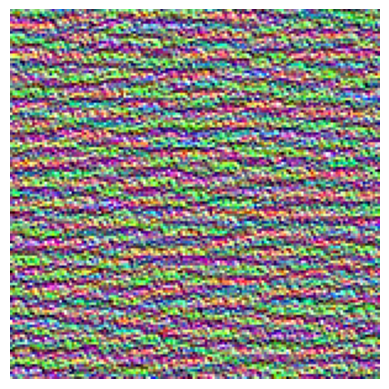

In [23]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))


In [24]:
# We can see that the filter number 2 of block3_seperable Conv2D has been responsive to horizontal wave curve lines

In [25]:
# Visualizing heat map of class activation : Helps us to identify which part of the image is used by the model to calculate the class of the model(i.e output of the network)

In [26]:
# Using Grad-CAM here : We use the output of the conv layer in the network and weigh each channel in the feature map by the gradient of each class with the channel

In [27]:
model = keras.applications.xception.Xception(weights="imagenet") # We are also taking the dense layers here (Because we need to get the output classes )

In [28]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [29]:
img_path = "artifacts\Elephants.png"

img_array = get_img_array(img_path=img_path,target_size=(299,299)) # Input shape of the model

In [30]:
img_array

array([[[[200., 209., 207.],
         [ 21.,  58.,  43.],
         [ 19.,  55.,  37.],
         ...,
         [ 54.,  91.,  68.],
         [107., 134., 119.],
         [255., 255., 255.]],

        [[ 19.,  58.,  43.],
         [ 19.,  55.,  38.],
         [ 27.,  62.,  43.],
         ...,
         [ 43.,  81.,  59.],
         [ 40.,  78.,  57.],
         [208., 215., 213.]],

        [[ 25.,  60.,  45.],
         [ 28.,  61.,  42.],
         [ 35.,  67.,  44.],
         ...,
         [ 39.,  78.,  59.],
         [ 34.,  73.,  55.],
         [ 99., 126., 116.]],

        ...,

        [[124., 171.,  57.],
         [137., 188.,  61.],
         [141., 192.,  68.],
         ...,
         [ 85., 120.,  70.],
         [ 84., 119.,  69.],
         [ 84., 121.,  64.]],

        [[137., 185.,  61.],
         [135., 186.,  56.],
         [127., 179.,  50.],
         ...,
         [ 88., 123.,  77.],
         [ 83., 118.,  74.],
         [ 88., 123.,  71.]],

        [[128., 179.,  45.],
       

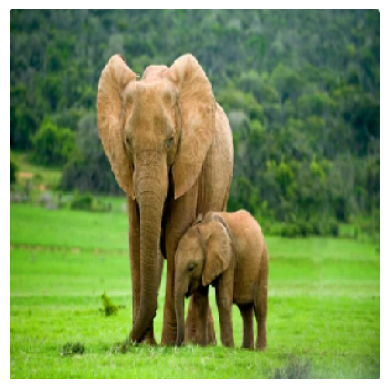

In [31]:
plt.axis("off")
plt.imshow(img_array[0].astype("uint8"))

In [32]:
img_tensor_preprocessed = keras.applications.xception.preprocess_input(img_array) # Preprocessing the input
preds = model.predict(img_tensor_preprocessed)
print(keras.applications.xception.decode_predictions(preds,top=3)[0]) # Printing the top 3 predictions by the model

1/1 [==============================] - 1s 710ms/step
[('n02504013', 'Indian_elephant', 0.5068954), ('n02504458', 'African_elephant', 0.30456233), ('n01871265', 'tusker', 0.10711887)]


In [34]:
# The model has identified its an indian elephant
# The class number : 385
np.argmax(preds[0])

385

In [35]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [37]:
# First we create a model that maps the input image of the last conv layer

last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_name = [ "avg_pool" , "predictions"]

last_conv_layer = model.get_layer(name=last_conv_layer_name)
last_conv_layer_model = Model(inputs=model.inputs,outputs = last_conv_layer.output)

In [38]:
from keras.layers import Input

In [39]:
last_conv_layer.output.shape

TensorShape([None, 10, 10, 2048])

In [51]:
# Creating a model that maps the output of the last conv layer to final class prediction

classifier_input_layer = Input(shape=last_conv_layer.output.shape[1:]) # 1: applied because we dont mention the batch dimension
x = classifier_input_layer

for layer_name in classifier_layer_name:
    x = model.get_layer(name=layer_name)(x) # We are fetching the layers from the model and creating the classifier model using the functional API

classifier_model = Model(inputs=classifier_input_layer,outputs = x)


In [52]:
classifier_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 10, 10, 2048)]    0         
                                                                 
 avg_pool (GlobalAveragePool  (None, 2048)             0         
 ing2D)                                                          
                                                                 
 predictions (Dense)         multiple                  2049000   
                                                                 
Total params: 2,049,000
Trainable params: 2,049,000
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Now we compute the gradient of the top predicted class wrt the activations (or output) of the last conv layer

In [60]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_tensor_preprocessed) # output of last conv layer model
    tape.watch(last_conv_layer_output) # watching the output of the last conv layer model
    preds = classifier_model(last_conv_layer_output) # The output of the last conv layer model used as an input for the classifier model
    top_pred_index = tf.argmax(preds[0]) # We are getting the class number or index of the most predicted class
    top_pred_index = 2
    top_class_channel = preds[:,top_pred_index] # We are getting the activation channel corresponding to the top predicted class(if class = 2, then the 2nd value in the preds tensor is selected, that will be the activation or output channel of the top predicted class)
grads = tape.gradient(top_class_channel,last_conv_layer_output)

In [61]:
# Now we apply the gradients pooling and channel importance weighting to the gradient tensor we got to get the heatmap

In [64]:
pooled_grads = tf.reduce_mean(grads,axis=(0,1,2)).numpy() # Creating the vector where each entry is the mean intensity of the gradient for a given channel( It helps in quantifying the importance of each channel wrt the top predicted class )

# Multiplying each channel in the output of the last conv layer by the importance of the channel
#last_conv_layer_output = last_conv_layer_output.numpy()[0] ( Only use when the last conv layer output is not an array)
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:,:,i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output,axis=-1) # Channel wise mean of the resulting feature map

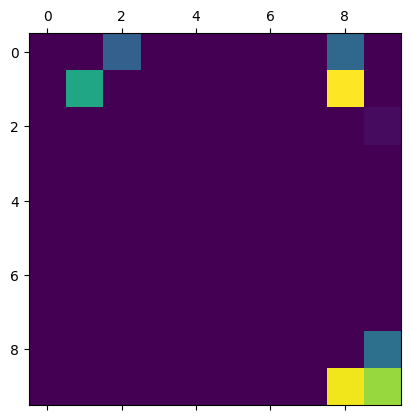

In [65]:
# Normalizing the heatmap between 0 and 1

heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [70]:
img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)
heatmap = np.uint8(255 * heatmap)
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]
jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)
save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

C:\Users\arany\AppData\Local\Temp\ipykernel_19224\793527392.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


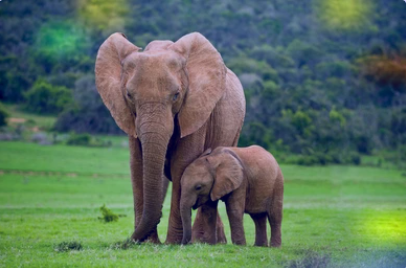

In [71]:
superimposed_img